## Tokamesh - mesh construction demo
This notebook demonstrates how tools from the `tokamesh.construction` module can be used to easily generate triangular meshes.

We will construct a mesh which fills the cross-section of the lower super-x divertor of the MAST-U tokamak.
The boundary of the super-x can be retrieved using the `tokamaks` module as follows

In [1]:
from tokamesh.tokamaks import mastu_boundary
R_boundary, z_boundary = mastu_boundary(lower_divertor=True)

The `mesh_generator` function constructs a triangular mesh which fills the space inside a given boundary. It combines an equilateral mesh, 
which fills the central area inside the boundary, with an irregular mesh which fills the space near the boundary.

In [2]:
from numpy import pi
from tokamesh.construction import mesh_generator

R, z, triangles = mesh_generator(
    R_boundary=R_boundary,
    z_boundary=z_boundary,
    resolution=0.04,
    rotation=0.25*pi,
    edge_padding=0.45,
)

We can use the `TriangularMesh` utility class to simplify plotting the mesh

In [3]:
from tokamesh import TriangularMesh
mesh = TriangularMesh(R, z, triangles)

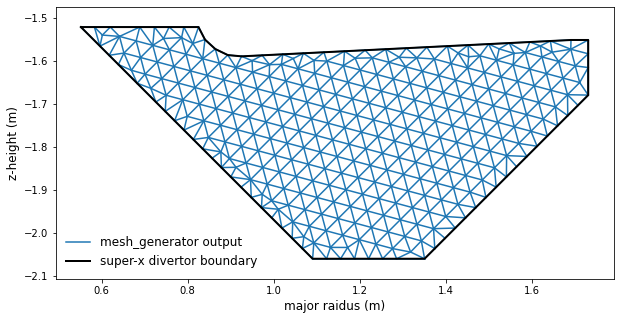

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure( figsize=(10,5) )
ax = fig.add_subplot(111)
mesh.draw(ax, c='C0', label='mesh_generator output')
ax.plot(R_boundary, z_boundary, lw=2, c='black', label='super-x divertor boundary')
ax.set_xlabel('major raidus (m)', fontsize=12)
ax.set_ylabel('z-height (m)', fontsize=12)
ax.axis('equal')
ax.legend(frameon=False, fontsize=12)
plt.show()

The `refine_mesh` function allows us to increase the density of the mesh over a chosen region by partitioning selected triangles.
To do this, we need to specify which triangles are partioned via an array of bools. As an example, we generate a bool array which
is `True` for triangles which lie close to a particular line segment:

In [5]:
# find the barycenter of each triangle
R_c = R[triangles].mean(axis=1)
z_c = z[triangles].mean(axis=1)
# coefficients for the line
m, c = -0.26943, -1.47745
# get the bools for whether each triangle meets the chosen condition
refine_bools = (abs(z_c - m*R_c - c) < 0.08) & (R_c > 1.1)

We can now pass the bools to `refine_mesh` along with the `R`, `z` and `triangle` arrays which define the current mesh, and any triangles corresponding to a `True` will be partitioned:

In [6]:
from tokamesh.construction import refine_mesh
R, z, triangles = refine_mesh(R, z, triangles, refine_bools)

Now plot the new refined mesh:

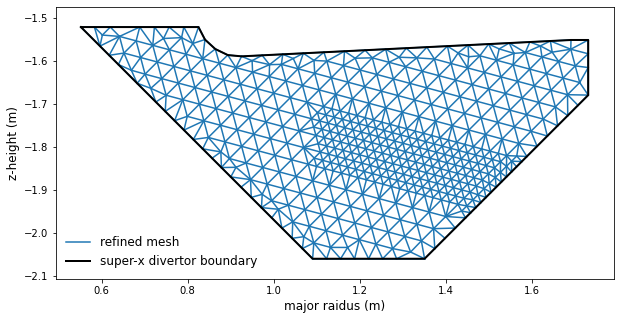

In [7]:
fig = plt.figure( figsize=(10,5) )
ax = fig.add_subplot(111)
mesh = TriangularMesh(R, z, triangles)
mesh.draw(ax, c='C0', label='refined mesh')
ax.plot(R_boundary, z_boundary, lw=2, c='black', label='super-x divertor boundary')
ax.set_xlabel('major raidus (m)', fontsize=12)
ax.set_ylabel('z-height (m)', fontsize=12)
ax.axis('equal')
ax.legend(frameon=False, fontsize=12)
plt.show()

There may be cases where you wish to remove certain vertices from the mesh - for example those which are not visible to a particular diagnostic.
This can be done easily using the `trim_vertices` function.

As an example we remove vertices in the throat of the super-x divertor by finding those which lie above a particular line:

In [8]:
# first generate bools specifying which vertices to trim
m, c = 0.05, -1.62 # coefficients of the line
vertices_to_trim = z > (R*m + c)
# now pass those bools to trim_vertices, along with the mesh data
from tokamesh.construction import trim_vertices
R, z, triangles = trim_vertices(R, z, triangles, vertices_to_trim)

Re-plot the mesh once more to see the effect:

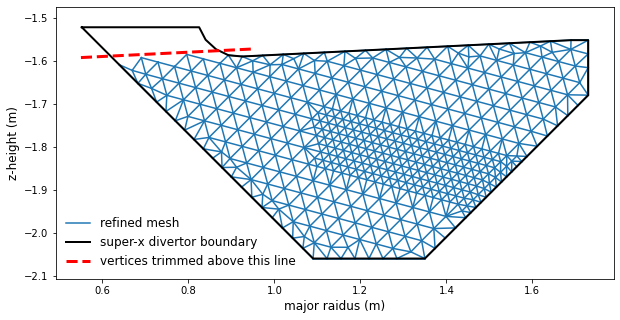

In [9]:
fig = plt.figure( figsize=(10,5) )
ax = fig.add_subplot(111)
mesh = TriangularMesh(R, z, triangles)
mesh.draw(ax, c='C0', label='refined mesh')
ax.plot(R_boundary, z_boundary, lw=2, c='black', label='super-x divertor boundary')
ax.plot([0.55, 0.95], [0.55*m+c, 0.95*m+c], color='red', ls='dashed', lw=3, label='vertices trimmed above this line')
ax.set_xlabel('major raidus (m)', fontsize=12)
ax.set_ylabel('z-height (m)', fontsize=12)
ax.axis('equal')
ax.legend(frameon=False, fontsize=12)
plt.show()